In [ ]:
# File: meta_agent_env.py
import os
import sys
import pandas as pd
import numpy as np
import gym
from gym import spaces

# === Add project root to path ===
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


def precompute_observations(data, advisors):
    extra_features = ["macd", "rsi_30", "cci_30", "vix", "turbulence", "close_30_sma", "close_60_sma"]
    # extra_features = []
    cached_obs = []

    for i in range(len(data)):
        row = data.iloc[i].to_dict()
        obs = []

        for name, agent in advisors.items():
            result = agent.analyze(row)
            action = result["action"]
            confidence = result["confidence"]
            for act in ["buy", "hold", "sell"]:
                obs.append(confidence if act == action else 0.0)

        obs.append(0.0)  # holding 状态初始化为 False

        for feat in extra_features:
            obs.append(row.get(feat, 0.0))

        cached_obs.append(np.array(obs, dtype=np.float32))

    return cached_obs


class MetaCIOEnv(gym.Env):
    def __init__(self, data, advisors, cached_obs=None):
        super(MetaCIOEnv, self).__init__()

        self.data = data.reset_index(drop=True)
        self.advisors = advisors
        self.cached_obs = cached_obs
        self.current_step = 0
        self.holding = False
        self.entry_price = 0.0
        self.holding_days = 0

        self.extra_features = ["macd", "rsi_30", "cci_30", "vix", "turbulence", "close_30_sma", "close_60_sma"]
        # self.extra_features = []
        obs_dim = len(advisors) * 3 + 1 + len(self.extra_features)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        self.action_space = spaces.Discrete(3)  # 0-buy, 1-hold, 2-sell

    def _get_obs(self):
        if self.cached_obs is not None:
            obs = self.cached_obs[self.current_step].copy()

            holding_index = len(self.advisors) * 3
            obs[holding_index] = 1.0 if self.holding else 0.0
            return obs
        else:
            row = self.data.iloc[self.current_step]
            obs = []
            for name, agent in self.advisors.items():
                result = agent.analyze(row.to_dict())
                action = result["action"]
                confidence = result["confidence"]
                for act in ["buy", "hold", "sell"]:
                    obs.append(confidence if act == action else 0.0)

            obs.append(1.0 if self.holding else 0.0)
            for feat in self.extra_features:
                obs.append(row.get(feat, 0.0))

            return np.array(obs, dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.holding = False
        self.entry_price = 0.0
        self.holding_days = 0
        return self._get_obs()

    def step(self, action):
        row = self.data.iloc[self.current_step]
        price = row["close"]

        reward = 0.0
        transaction_cost = 0.001

        if action == 0 and not self.holding:
            self.holding = True
            self.entry_price = price
            self.holding_days = 0
            # reward -= price * transaction_cost
        elif action == 2 and self.holding:
            pnl = (price - self.entry_price) / self.entry_price
            reward += pnl
            # reward -= price * transaction_cost
            self.holding = False
            self.entry_price = 0.0
            self.holding_days = 0
        elif self.holding:
            # Holding penalty, no realized pnl
            reward -= 0.0005
            self.holding_days += 1

        self.current_step += 1
        done = self.current_step >= len(self.cached_obs) - 1
        obs = self._get_obs()

        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}")


from agent_tools.open_ai.agent_roles_openai import (
    TechnicalAnalystAgent, SentimentAnalystAgent, MacroAnalystAgent, RiskAnalystAgent
)
from stable_baselines3 import PPO

df = pd.read_csv("../../datasets/processed/financial_with_news_macro_summary.csv")

advisors = {
    "tech": TechnicalAnalystAgent(),
    "sent": SentimentAnalystAgent(),
    "macro": MacroAnalystAgent(),
    "risk": RiskAnalystAgent()
}


In [11]:
from agent_tools.open_ai.agent_roles_openai import (
        TechnicalAnalystAgent, SentimentAnalystAgent, MacroAnalystAgent, RiskAnalystAgent
    )
from stable_baselines3 import PPO

df = pd.read_csv("../../datasets/processed/financial_with_news_macro_summary.csv")

advisors = {
    "tech": TechnicalAnalystAgent(),
    "sent": SentimentAnalystAgent(),
    "macro": MacroAnalystAgent(),
    "risk": RiskAnalystAgent()
}

cache_path = "cached_observations_test.csv"

if os.path.exists(cache_path):
    print(f"Loading cached observations from {cache_path} ...")
    df_cached = pd.read_csv(cache_path)
    cached_obs = df_cached.values.astype(np.float32)
else:
    print("Cached observations not found, precomputing...")
    cached_obs = precompute_observations(df, advisors)
    cached_obs_array = np.stack(cached_obs)
    pd.DataFrame(cached_obs_array).to_csv(cache_path, index=False)
    print(f"Cached observations saved to {cache_path}")

Loading cached observations from cached_observations_test.csv ...


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step: 1
0
Step: 2
0
Step: 3
0
Step: 4
0
Step: 5
0
Step: 6
0
Step: 7
0
Step: 8
0
Step: 9
0
Step: 10
2
Step: 11
2
Step: 12
0
Step: 13
0
Step: 14
1
Step: 15
0
Step: 16
1
Step: 17
0
Step: 18
1
Step: 19
0
Step: 20
0
Step: 21
2
Step: 22
0
Step: 23
0
Step: 24
2
Step: 25
0
Step: 26
0
Step: 27
0
Step: 28
0
Step: 29
2
Step: 30
2
Step: 31
1
Step: 32
2
Step: 33
0
Step: 34
0
Step: 35
2
Step: 36
1
Step: 37
1
Step: 38
0
Step: 39
1
Step: 40
1
Step: 41
0
Step: 42
0
Step: 43
1
Step: 44
0
Step: 45
0
Step: 46
0
Step: 47
0
Step: 48
0
Step: 49
0
Final Portfolio Value: $ 1124.59
Total Profit: $ 124.59


/data/postgraduates/2024/chenjiarui/anaconda3/envs/Qwen-Py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/data/postgraduates/2024/chenjiarui/anaconda3/envs/Qwen-Py310/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on

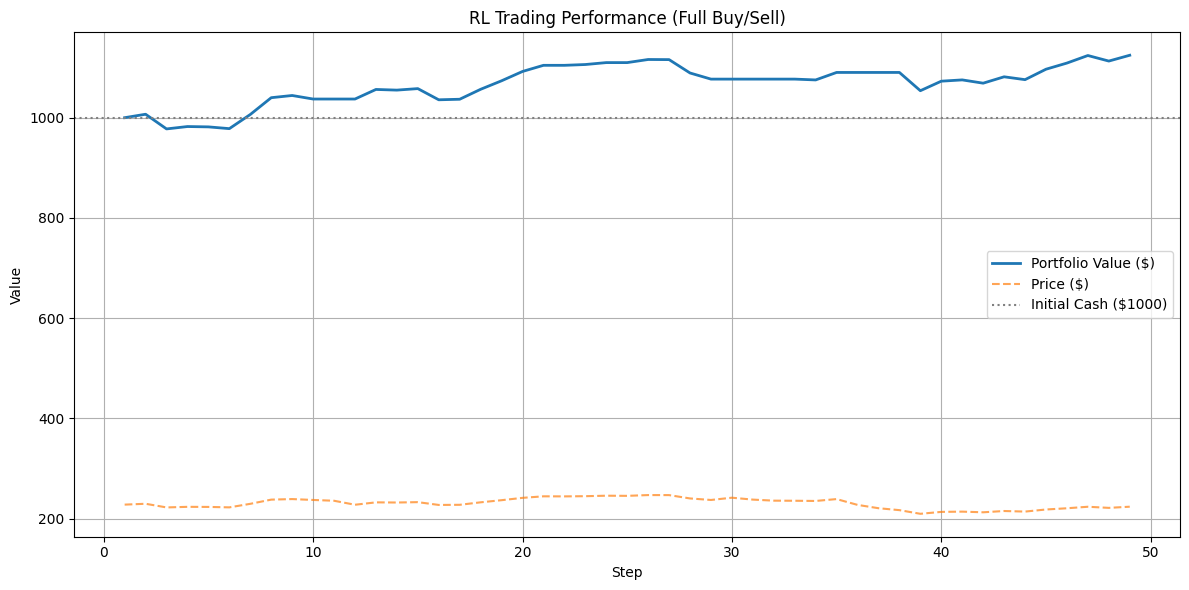

In [12]:
import matplotlib.pyplot as plt

# 初始化环境与模型
env = MetaCIOEnv(df.tail(50).reset_index(drop=True), advisors, cached_obs=cached_obs)
model = PPO.load("meta_cio_rl_cached", env=env)

# 初始资金
initial_cash = 1000.0
cash = initial_cash
shares = 0  # 当前持有股票数量

# 重置环境
obs = env.reset()
done = False

# 记录曲线数据
portfolio_values = []
prices = []
steps = []
rewards = []

while not done:
    row = env.data.iloc[env.current_step]
    price = row["close"]

    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)

    # 全部买入
    if action == 0 and shares == 0:
        shares = int(cash // price)  # 全部买入
        cash -= shares * price

    # 全部卖出
    elif action == 2 and shares > 0:
        cash += shares * price
        shares = 0

    current_value = cash + shares * price

    rewards.append(reward)
    portfolio_values.append(current_value)
    prices.append(price)
    steps.append(env.current_step)

    env.render()
    print(action)

# 输出最终收益
final_value = portfolio_values[-1]
total_profit = final_value - initial_cash
print("Final Portfolio Value: $", round(final_value, 2))
print("Total Profit: $", round(total_profit, 2))

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(steps, portfolio_values, label='Portfolio Value ($)', linewidth=2)
plt.plot(steps, prices, label='Price ($)', linestyle='--', alpha=0.7)
plt.axhline(initial_cash, color='gray', linestyle=':', label='Initial Cash ($1000)')
plt.title('RL Trading Performance (Full Buy/Sell)')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
